In [1]:
import open3d as o3d
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
class Box():
    def __init__(self, **kwargs):
        self.cx = kwargs['cx']
        self.cy = kwargs['cy']
        self.cz = kwargs['cz']
        self.heading = kwargs['heading'] / 100.0
        self.l = kwargs['l']
        self.w = kwargs['w']
        self.h = kwargs['h']
        self.point_index = kwargs['point_index']
        self.matrix = None
        self.matrix_2_global()

    def matrix_2_global(self):
        theta = np.deg2rad(self.heading % 360)
        r = np.array([[np.cos(theta), -np.sin(theta), 0],
                      [np.sin(theta), np.cos(theta), 0],
                      [0, 0, 1]])
        t = np.array([self.cz, self.cy, self.cx])
        trans_matrix = np.eye(4)
        trans_matrix[0:3, 0:3] = r
        trans_matrix[0:3, 3] = t
        self.matrix = trans_matrix

In [3]:
def read_pcd(filename):
    pcd = o3d.io.read_point_cloud(filename)
    return pcd.points


def write_pcd(points, k):
    new_p = []
    for i in points:
        new_p.append([0, i[1], i[0]])
    new_p = np.array(new_p)
    # 写pcd文件
    pp = o3d.geometry.PointCloud()
    pp.points = o3d.utility.Vector3dVector(new_p)
    o3d.io.write_point_cloud(f"{k}-output.pcd", pp)

In [4]:
def read_box_pcd(filepath, idx, id):
    from cyber_record.record import Record
    box = None
    pcd = None
    try:
        record = Record(filepath)
    except Exception as e:
        print(file)
    for topic, message, t in record.read_messages():
        try:
            tidx = message.idx
        except AttributeError:
            continue
        if idx != tidx:
            continue
        if topic == 'omnisense/track_fusion/boxes':
            for t_box in message.box:
                if t_box.track_id == id:
                    tmp = {
                        'cx': t_box.position_x,
                        'cy': t_box.position_y,
                        'cz': t_box.position_z,
                        'heading': t_box.spindle,
                        'l': t_box.length,
                        'w': t_box.width,
                        'h': t_box.height,
                        'point_index': t_box.point_index
                    }
                    box = Box(**tmp)
        elif topic == 'omnisense/track_fusion/foreground/dynamic_pointcloud':
            pcd = message
        if box and pcd:
            return box, pcd
    return box, pcd

In [7]:
def filter_points(box, points):
    pcd = []
    for i in box.point_index:
        pt = points.point[i]
        pcd.append([pt.z, pt.y, pt.x])
    return np.array(pcd)

In [6]:
def rasterize_points(points, box, grid_size=0.1):

    min_z = -1 * box.l
    max_z = box.l
    min_y = -1 * box.w
    max_y = box.w

    rows = int((max_z - min_z) / grid_size) + 1
    cols = int((max_y - min_y) / grid_size) + 1

    # 创建栅格 (二维数组)
    raster_grid = [[] for i in range(rows * cols)]
    raster_grid_l = np.zeros([rows, cols])

    # 将点放入相应的栅格中
    for i in range(len(points)):
        point = points[i]
        grid_x = int((point[0] - min_z) / grid_size)
        grid_y = int((point[1] - min_y) / grid_size)
        index = (grid_x - 1) * cols + grid_y - 1
        if grid_x == 200:
            continue
        if 0 <= index < rows * cols:
            raster_grid[index].append(i)
            raster_grid_l[grid_x, grid_y] += 1

    return raster_grid, raster_grid_l, [min_z, max_z, min_y, max_y]

In [8]:
def rotate_points(points, box):
    rotation_matrix = np.linalg.inv(box.matrix)

    # 将点集进行旋转
    num_points = points.shape[0]
    homogeneous_points = np.hstack((points, np.ones((num_points, 1))))
    rotated_points = homogeneous_points @ rotation_matrix.T
    return rotated_points[:, 0:3]  # z y x

In [9]:
def label_connected_components(image, labeled_image, r, c, l):
    rows, cols = image.shape
    for dr, dc in [(1, 0), (1, 1)]:
        nc, nr = c + dc, r + dr
        if 0 <= nr < rows and 0 <= nc < cols and image[nr, nc] > 0:
            labeled_image[nr, nc] += 1
            l.append([nr, nc])
            label_connected_components(image, labeled_image, nr, nc, l)
    return


def neighbour(rasterize_):
    rows, cols = rasterize_.shape
    labeled_image = np.zeros([rows, cols], dtype=np.uint8)
    del_points = []
    for i in range(1, cols - 1):
        if np.sum(rasterize_[:, i]) > 0 and np.sum(rasterize_[:, i + 1]) == 0:
            continue
        for j in range(1, rows - 1):
            if rasterize_[j, i] > 0 and labeled_image[j, i] == 0:
                p_set = [[j, i]]
                label_connected_components(
                    rasterize_, labeled_image, j, i, p_set)
                if len(p_set) < 10:
                    for p in p_set:
                        rasterize_[p[0], p[1]] = 0
                    del_points.extend(p_set)
    return del_points

In [10]:
file = '/home/demo/Documents/datasets/04/04-2.00000'
idx = 166825  # 152812
boxid = 8
box, points = read_box_pcd(file, idx, boxid)
print(box.l)
print(box.w)
print(box.h)
points = filter_points(box, points)
write_pcd(points[:, 0:2], f'{idx}-{boxid}-org')

17.456806182861328
2.8488943576812744
4.247570514678955


In [11]:
rotated_points_ = rotate_points(points, box)
write_pcd(rotated_points_[:, 0:2], f'{idx}-{boxid}-rotated')

In [12]:
grip_size = 0.2
rasterize_points_, rasterize_, bounds = rasterize_points(
    rotated_points_, box, grip_size)

In [36]:
rows, cols = rasterize_.shape
# for i in range(cols):
#     tmp_pts = []
#     for j in range(rows):
#         index = (j - 1) * cols + i - 1
#         for ii in rasterize_points_[index]:
#             tmp_pts.append(points[ii])
#     if not tmp_pts:
#         continue
#     write_pcd(np.array(tmp_pts)[:, 0:2],
#               f'{idx}-{boxid}-{grip_size}-col-{i}-filter')

for i in range(rows):
    tmp_pts = []
    for j in range(cols):
        index = (i - 1) * cols + j - 1
        for ii in rasterize_points_[index]:
            tmp_pts.append(points[ii])
    if not tmp_pts:
        continue
    write_pcd(np.array(tmp_pts)[:, 0:2],
              f'{idx}-{boxid}-{grip_size}-row-{i}-filter')

In [13]:
rows, cols = rasterize_.shape
del_col = []
del_row = []

for i in range(0, cols):
    valid_rows = np.where(rasterize_[:, i] > 0)[0]
    if len(valid_rows) == 0:
        continue
    count = np.sum(rasterize_[:, i] > 0)
    max_row = valid_rows.max()
    min_row = valid_rows.min()
    if count < 20 or max_row - min_row < rows / 3:
        del_col.append(i)
    else:
        break

for i in range(cols - 1, -1, -1):
    valid_rows = np.where(rasterize_[:, i] > 0)[0]
    if len(valid_rows) == 0:
        continue
    count = np.sum(rasterize_[:, i] > 0)
    max_row = valid_rows.max()
    min_row = valid_rows.min()
    if count < 20 or max_row - min_row < rows / 3:
        del_col.append(i)
    else:
        break

for i in range(0, rows):
    valid_cols = np.where(rasterize_[i, :] > 0)[0]
    if len(valid_cols) == 0:
        continue
    count = np.sum(rasterize_[i, :] > 0)
    max_col = valid_cols.max()
    min_col = valid_cols.min()
    if count < 10 or max_col - min_col < cols / 5:
        del_row.append(i)
    else:
        break

for i in range(rows - 1, -1, -1):
    valid_cols = np.where(rasterize_[i, :] > 0)[0]
    if len(valid_cols) == 0:
        continue
    count = np.sum(rasterize_[i, :] > 0)
    max_col = valid_cols.max()
    min_col = valid_cols.min()
    if count < 10 or max_col - min_col < cols / 5:
        del_row.append(i)
    else:
        break

rows_to_del = []
for i in del_col:
    for j in range(rows):
        index = (j - 1) * cols + i - 1
        for ii in rasterize_points_[index]:
            rows_to_del.append(ii)
for i in del_row:
    for j in range(cols):
        index = (i - 1) * cols + j - 1
        for ii in rasterize_points_[index]:
            rows_to_del.append(ii)

new_array = np.delete(points, rows_to_del, axis=0)
write_pcd(new_array[:, 0:2], f'{idx}-{boxid}-{grip_size}-filter')

In [13]:
rows, cols = rasterize_.shape
del_col = []
del_row = []
for i in range(cols):
    valid_rows = np.where(rasterize_[:, i] > 0)[0]
    if len(valid_rows) == 0:
        continue
    count = np.sum(rasterize_[:, i] > 0)
    max_row = valid_rows.max()
    min_row = valid_rows.min()
    if count < 10 or max_row - min_row < rows / 3:
        del_col.append(i)

for i in range(rows):
    valid_cols = np.where(rasterize_[i, :] > 0)[0]
    if len(valid_cols) == 0:
        continue
    count = np.sum(rasterize_[i, :] > 0)
    max_col = valid_cols.max()
    min_col = valid_cols.min()
    if count < 3 or max_col - min_col < cols / 5:
        del_row.append(i)

rows_to_del = []
for i in del_col:
    for j in range(rows):
        index = (j - 1) * cols + i - 1
        for ii in rasterize_points_[index]:
            rows_to_del.append(ii)
for i in del_row:
    for j in range(cols):
        index = (i - 1) * cols + j - 1
        for ii in rasterize_points_[index]:
            rows_to_del.append(ii)

new_array = np.delete(points, rows_to_del, axis=0)
write_pcd(new_array[:, 0:2], f'{idx}-{boxid}-{grip_size}-filter')

In [1]:
del_points = neighbour(rasterize_)
rows_to_del = []
rows, cols = rasterize_.shape
for p in del_points:
    index = (p[0] - 1) * cols + p[1] - 1
    for i in rasterize_points_[index]:
        rows_to_del.append(i)

new_array = np.delete(points, rows_to_del, axis=0)
write_pcd(new_array[:, 0:2], f'{idx}-{boxid}-{grip_size}-n-filter')

NameError: name 'neighbour' is not defined

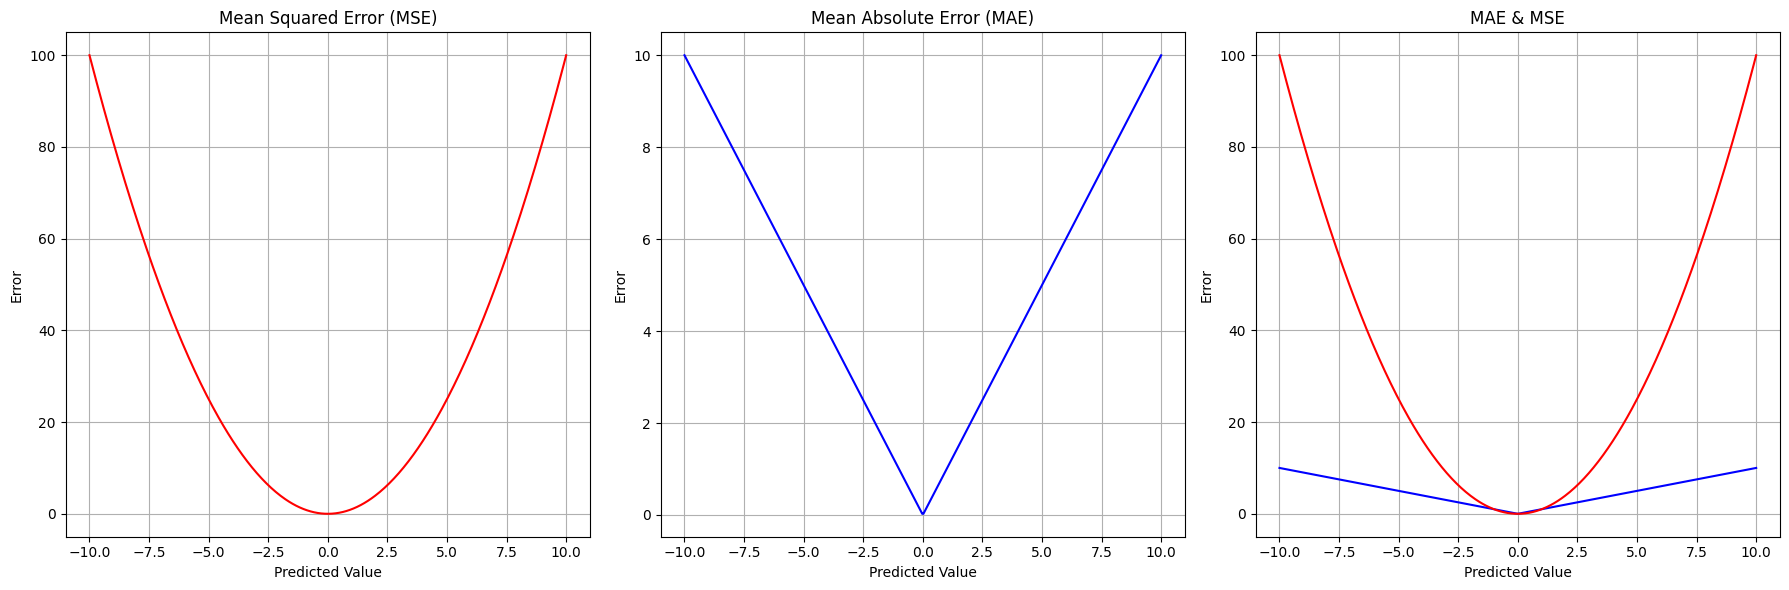

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 生成真实值和预测值之间的差距
y_true = 0  # 假设真实值为0
predictions = np.linspace(-10, 10, 400)  # 从-10到10生成400个预测值

# 计算MAE和MSE
mae = np.abs(y_true - predictions)
mse = (y_true - predictions) ** 2

# 绘制图形
plt.figure(figsize=(18, 6))

# MSE图
plt.subplot(1, 3, 1)
plt.plot(predictions, mse, color='red')
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Predicted Value')
plt.ylabel('Error')
plt.grid(True)

# MAE图
plt.subplot(1, 3, 2)
plt.plot(predictions, mae, color='blue')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Predicted Value')
plt.ylabel('Error')
plt.grid(True)

# MAE图
plt.subplot(1, 3, 3)
plt.plot(predictions, mae, color='blue')
plt.plot(predictions, mse, color='red')
plt.title('MAE & MSE')
plt.xlabel('Predicted Value')
plt.ylabel('Error')
plt.grid(True)

# 显示图形
plt.tight_layout()
plt.show()

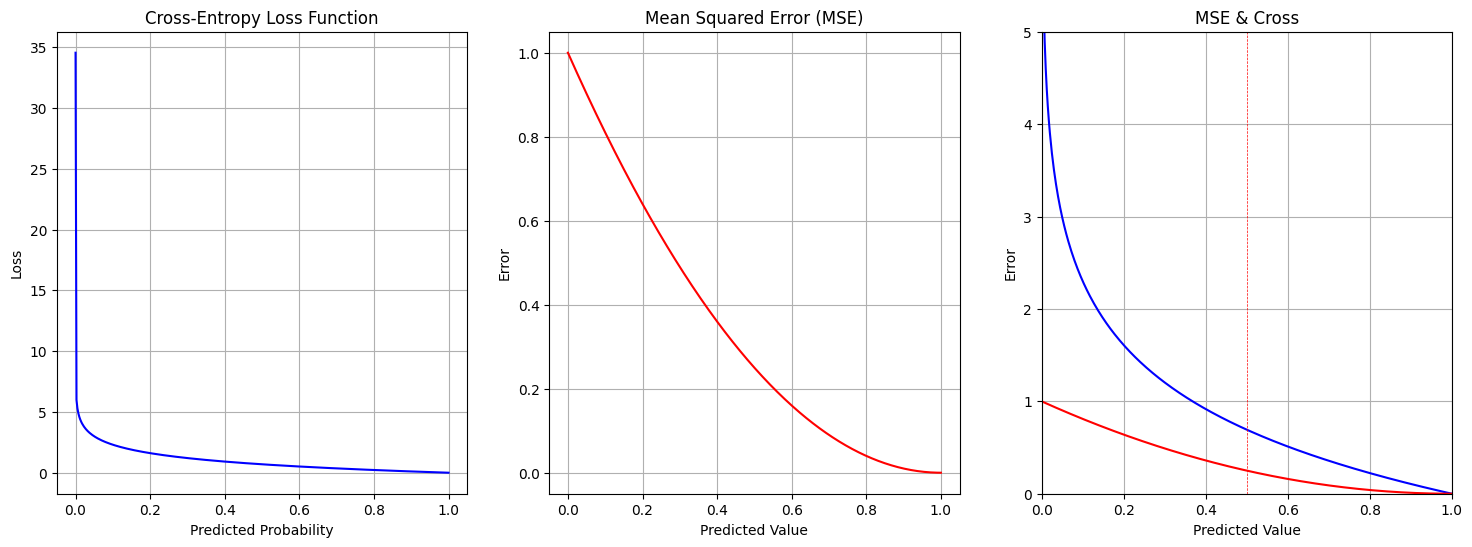

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 定义交叉熵损失函数


def cross_entropy_loss(y_true, y_pred):
    # 为了避免对数为零，添加一个小常数epsilon
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # 限制y_pred在(0, 1)之间
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))


# 生成真实标签
y_true = np.array([1])  # 假设真实标签为1
y_pred_values = np.linspace(0, 1, 400)  # 从0到1生成400个预测值

# 计算交叉熵损失
loss_values = [cross_entropy_loss(y_true, y_pred) for y_pred in y_pred_values]
mse = (y_true - y_pred_values) ** 2

# 绘制图形
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(y_pred_values, loss_values, color='blue')
plt.title('Cross-Entropy Loss Function')
plt.xlabel('Predicted Probability')
plt.ylabel('Loss')
plt.grid(True)


# MSE图
plt.subplot(1, 3, 2)
plt.plot(y_pred_values, mse, color='red')
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Predicted Value')
plt.ylabel('Error')
plt.grid(True)

# MSE图
plt.subplot(1, 3, 3)
plt.plot(y_pred_values, loss_values, color='blue')
plt.plot(y_pred_values, mse, color='red')
plt.title('MSE & Cross')
plt.xlabel('Predicted Value')
plt.ylabel('Error')
plt.grid(True)

# 显示图形
plt.xlim(0, 1)
plt.ylim(0, 5)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0.5, color='red', linewidth=0.5, linestyle='--')  # 标记概率为0.5的位置
plt.show()

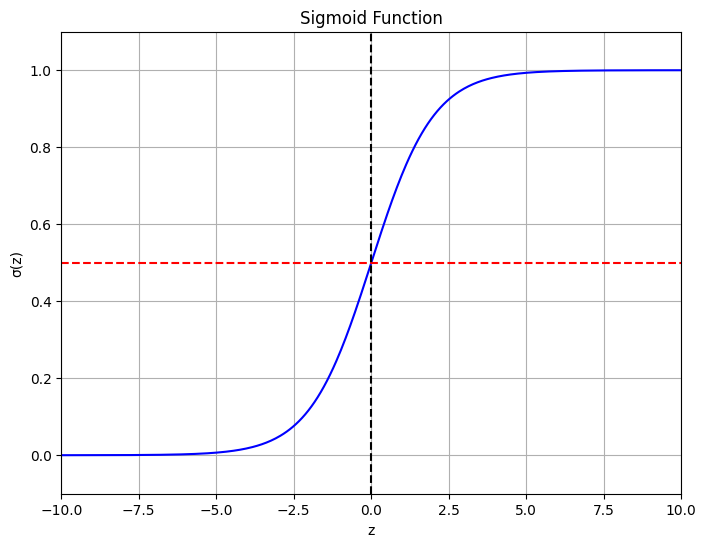

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 定义sigmoid函数


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# 生成z值
z_values = np.linspace(-10, 10, 400)  # 从-10到10生成400个值
sigmoid_values = sigmoid(z_values)     # 计算对应的sigmoid值

# 绘制图形
plt.figure(figsize=(8, 6))
plt.plot(z_values, sigmoid_values, color='blue')
plt.title('Sigmoid Function')
plt.xlabel('z')
plt.ylabel('σ(z)')
plt.axhline(0.5, color='red', linestyle='--')  # 添加y=0.5的虚线
plt.axvline(0, color='black', linestyle='--')  # 添加x=0的虚线
plt.grid(True)
plt.xlim(-10, 10)
plt.ylim(-0.1, 1.1)

# 显示图形
plt.show()